#### Authors
#### Νικόλας Ηλιόπουλος 1115201800332
#### Μιχάλης Βολάκης 1115201800022

# Imports & Functions

In [8]:
import numpy as np
import math
import pandas as pd

from sklearn.preprocessing import StandardScaler
from pandas.core.frame import DataFrame
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})

from sklearn.preprocessing import FunctionTransformer

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.inspection import permutation_importance

import sklearn.metrics as metrics

import folium

In [9]:
# Calculate Day period from hour 
def findDayPeriod(x):
    if (x >= 6) and (x < 12):
        return 'Morning'
    elif (x >= 12) and (x < 16 ):
        return 'Afternoon'
    elif (x >= 16) and (x < 22):
        return 'Evening'
    else:
        return 'Late Night'

# calculate manhattan distance from coordinates
def get_manhattan_distance(long0,lat0,long1,lat1):

    long0, lat0, long1, lat1 = map(np.radians, [long0, lat0, long1, lat1])

    newlong = long1 - long0
    newlat = lat1 - lat0

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat0) * np.cos(lat1) * np.sin(newlong/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

# speed in km/h
def calc_avg_speed(dist, time):
    return 3600 * (dist / time)

def get_color(i):
  if(i == 0):
    return 'blue'
  elif(i == 1):
    return 'green'
  elif(i == 2):
    return 'orange'
  elif(i == 3):
    return 'purple'
  elif(i == 4):
    return 'yellow'

# Import datasets

In [10]:
data_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataSets/tede2/train.csv")
data_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataSets/tede2/test.csv")
data_target = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataSets/tede2/target.csv")

# Ανάλυση Δεδομένων

## 1. Αφαίρεση Outliers
Αφαίρεση outliers (ακραία data samples) για την καλύτερη διαχείριση των δεδομένων.

*Drop* all the rows that are smaller than μ-2σ and bigger than μ+2σ

In [11]:
std = data_train.describe()['trip_duration']['std']
mean = data_train.describe()['trip_duration']['mean']
print("std:",std)
print("mean:",mean)
data_train = data_train.drop(data_train[(data_train['trip_duration'] <= mean - 2 * std) | (data_train['trip_duration'] >= mean + 2 * std)].index)

std: 5334.344536075008
mean: 958.4392359340654


## 2. Αφαίρεση Σημείων εκτός γεωγραφικών ορίων
Τα όρια της πόλης της NY με γεωγραφικά μήκη και πλάτη είναι:

**city_long_border = (-74.03, -73.75)**

**city_lat_border = (40.63, 40.85)**

Αφαίρεση όλων των σημείων που πέφτουν εκτός αυτών των ορίων.

In [12]:
data_train = data_train.drop(data_train[(data_train['pickup_longitude'] < -74.03) | (data_train['pickup_longitude'] > -73.75)].index)
data_train = data_train.drop(data_train[(data_train['pickup_latitude'] < 40.63) | (data_train['pickup_latitude'] > 40.85)].index)
data_train = data_train.drop(data_train[(data_train['dropoff_longitude'] < -74.03) | (data_train['dropoff_longitude'] > -73.75)].index)
data_train = data_train.drop(data_train[(data_train['dropoff_latitude'] < 40.63) | (data_train['dropoff_latitude'] > 40.85)].index)

## 3. Διαχωρισμός ημερομηνιών σε στήλες
Διαχωρισμός ημερομηνιών σε στήλες με χρήστη του DatetimeIndex απο Pandas

In [13]:
for categ in ['pickup', 'dropoff']:
    data_train['%s_datetime' % categ] = pd.to_datetime(data_train['%s_datetime' % categ])
    data_train['%s_datetime_hour' % categ] = pd.DatetimeIndex(data_train['%s_datetime' % categ]).hour;
    data_train['%s_datetime_month' % categ] = pd.DatetimeIndex(data_train['%s_datetime' % categ]).month;
    data_train['%s_datetime_year' % categ] = pd.DatetimeIndex(data_train['%s_datetime' % categ]).year
    data_train['%s_datetime_day_period' % categ] = data_train['%s_datetime_hour' % categ].apply(findDayPeriod)
    data_train['%s_datetime_day_name' % categ] = pd.DatetimeIndex(data_train['%s_datetime' % categ]).day_name()
    data_train['%s_datetime_season' % categ] = pd.DatetimeIndex(data_train['%s_datetime' % categ]).month%12 // 3 + 1

data_test['pickup_datetime'] = pd.to_datetime(data_test['pickup_datetime'])
data_test['pickup_datetime_hour'] = pd.DatetimeIndex(data_test['pickup_datetime']).hour
data_test['pickup_datetime_month'] = pd.DatetimeIndex(data_test['pickup_datetime']).month
data_test['pickup_datetime_year'] = pd.DatetimeIndex(data_test['pickup_datetime']).year
data_test['pickup_datetime_day_period'] = data_test['pickup_datetime_hour'].apply(findDayPeriod)
data_test['pickup_datetime_day_name'] = pd.DatetimeIndex(data_test['pickup_datetime']).day_name()
data_test['pickup_datetime_season'] = pd.DatetimeIndex(data_test['pickup_datetime']).month%12 // 3 + 1

### Ιστογράμματα

#### Πιο πολυσύχναστες Pickup Days

Η Παρασκευή φαίνεται να είναι η πιο πολυσύχναστη μέρα (ως η τελευταία εργάσιμη μέρα).

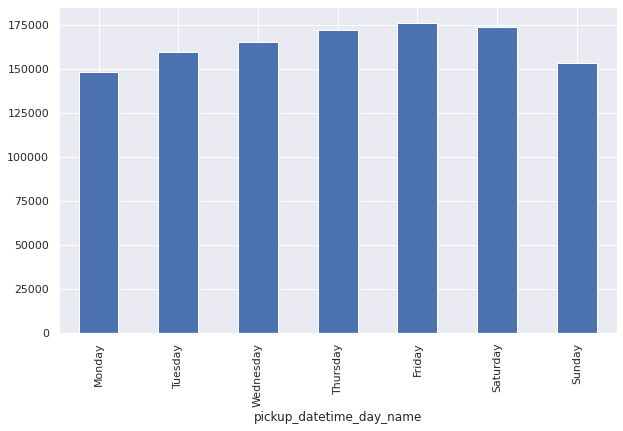

In [14]:
categories = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'];
cat_type = CategoricalDtype(categories=categories, ordered=True)
data_train['pickup_datetime_day_name'] = data_train['pickup_datetime_day_name'].astype(cat_type);

grouped = data_train.groupby('pickup_datetime_day_name')['id'].count();
grouped.plot(kind='bar');
plt.show();

#### Πιο πολυσύχναστες Dropoff Days

Είναι λογικό αφού η πιο πολυσύχναστη pickup day ήταν η Παρασκευή τότε και η πιο πολυσύχναστη dropoff day να είναι πάλι η Παρασκευή.

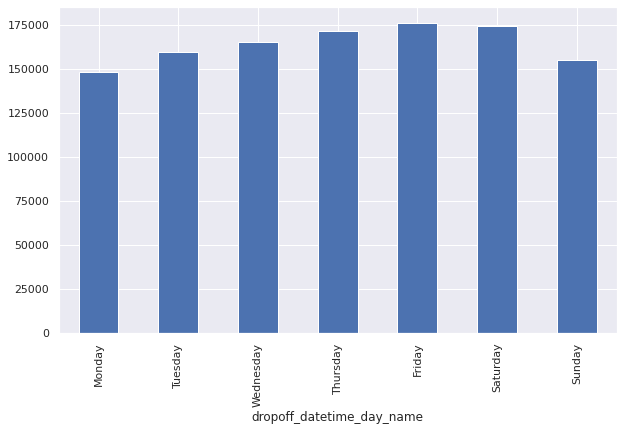

In [15]:
data_train['dropoff_datetime_day_name'] = data_train['dropoff_datetime_day_name'].astype(cat_type);
grouped = data_train.groupby('dropoff_datetime_day_name')['id'].count();
grouped.plot(kind='bar');
plt.show()

#### Trips per Day Period (για pickup και dropoff)

Λογικό το μεσημέρι να γίνονται τα πιο πολλά trips

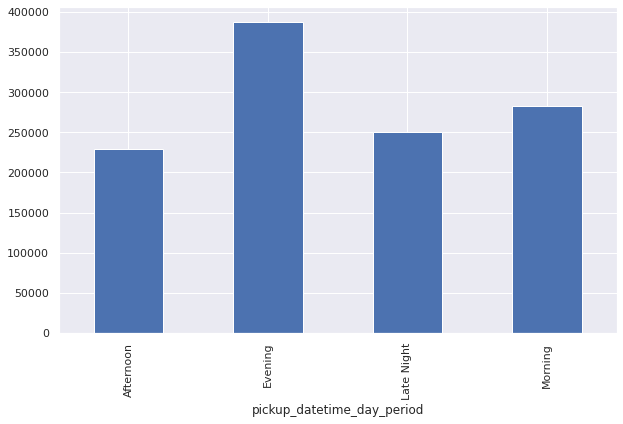

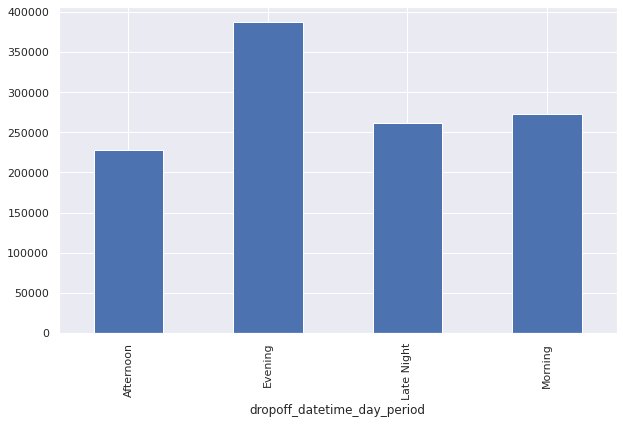

In [16]:
grouped = data_train.groupby('pickup_datetime_day_period')['id'].count();
grouped.plot(kind='bar');
plt.show()

grouped = data_train.groupby('dropoff_datetime_day_period')['id'].count();
grouped.plot(kind='bar');
plt.show()

#### Trips per month (για pickup και dropoff)

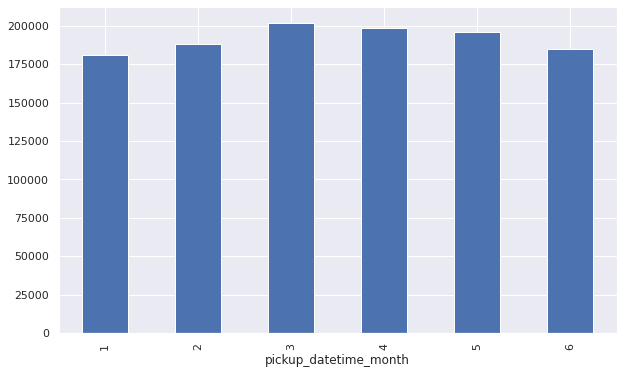

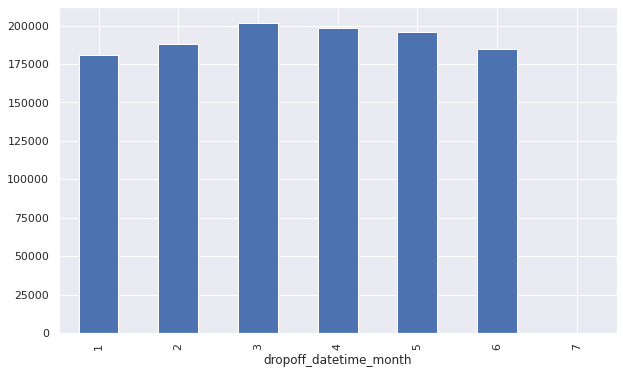

In [17]:
grouped = data_train.groupby('pickup_datetime_month')['id'].count();
grouped.plot(kind='bar');
plt.show()

grouped = data_train.groupby('dropoff_datetime_month')['id'].count();
grouped.plot(kind='bar');
plt.show()

#### Μέση διάρκεια ταξιδιού ανά Pickup Ηour

Tο μεσημέρι γίνονται τα περισσότερα trips αλλά ταυτόχρονα αυτά τα trips έχουν και την μεγαλύτερη διάρκεια.

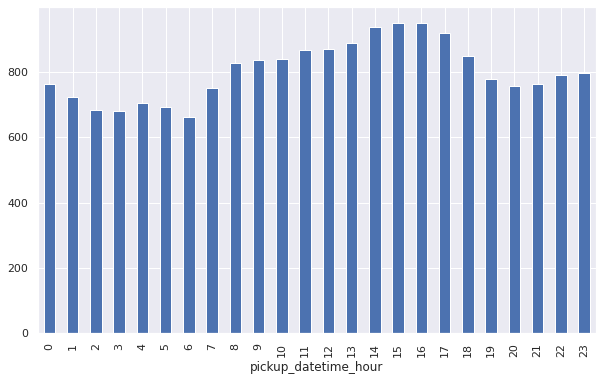

In [18]:
grouped = data_train.groupby('pickup_datetime_hour')['trip_duration'].mean();
grouped.plot(kind='bar');
plt.show()

#### Μέση διάρκεια ταξιδιού ανά Day Period

Το αποτέλεσμα συμβαδίζει με το προηγούμενο αποτέλεσμα

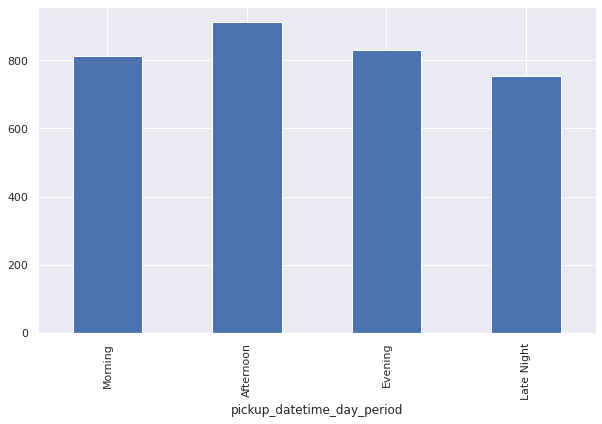

In [19]:
categories = ['Morning', 'Afternoon', 'Evening', 'Late Night'];
cat_type = CategoricalDtype(categories=categories, ordered=True)
data_train['pickup_datetime_day_period'] = data_train['pickup_datetime_day_period'].astype(cat_type);

grouped = data_train.groupby('pickup_datetime_day_period')['trip_duration'].mean();
grouped.plot(kind='bar');
plt.show()

#### Μέση διάρκεια ταξιδιού ανά Day of Week

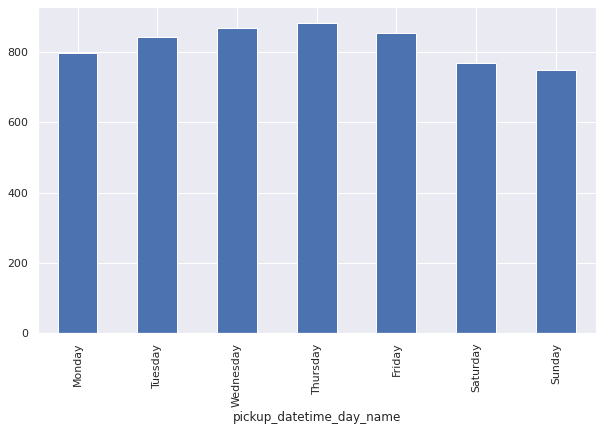

In [20]:
categories = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'];
cat_type = CategoricalDtype(categories=categories, ordered=True)
data_train['pickup_datetime_day_name'] = data_train['pickup_datetime_day_name'].astype(cat_type);

grouped = data_train.groupby('pickup_datetime_day_name')['trip_duration'].mean();
grouped.plot(kind='bar');
plt.show()

## 4 Ιστόγραμμα για τη στήλη trip_duration & log_trip_duration

Βλέπουμε ότι το log_trip_duration ακολουθεί κανονική κατανομή

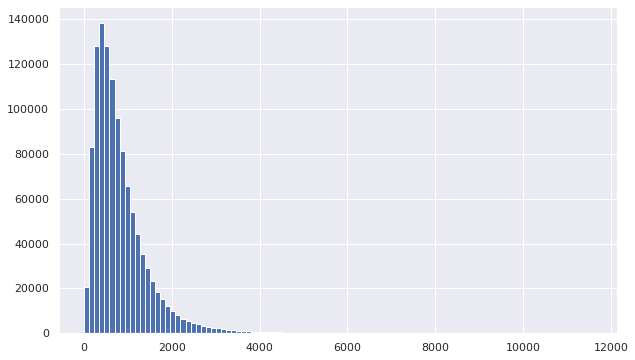

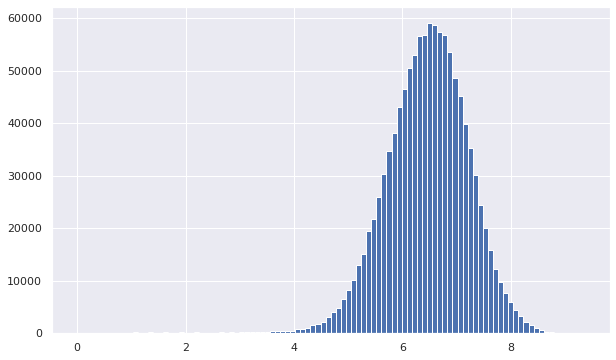

In [21]:
data_train['trip_duration'].hist(bins=100);
plt.show()
data_train['log_trip_duration'] =  np.log(data_train['trip_duration']);
data_train['log_trip_duration'].hist(bins=100);
plt.show()

## 5 Μέση διάρκεια ταξιδιού για τους διαθέσιμους παρόχους

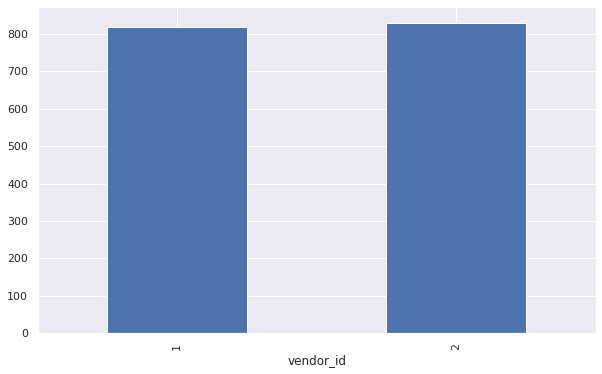

In [22]:
grouped = data_train.groupby('vendor_id')['trip_duration'].mean();
grouped.plot(kind='bar');
plt.show();

## 6 Aριθμός των επιβατών ανά ταξίδι στον χρόνο τους ταξιδιού

Βλέπουμε ότι δεν έχει πολύ σημασία είτε υπάρχει ένας passenger είτε 6 passengers για την διάρκεια του ταξιδιού

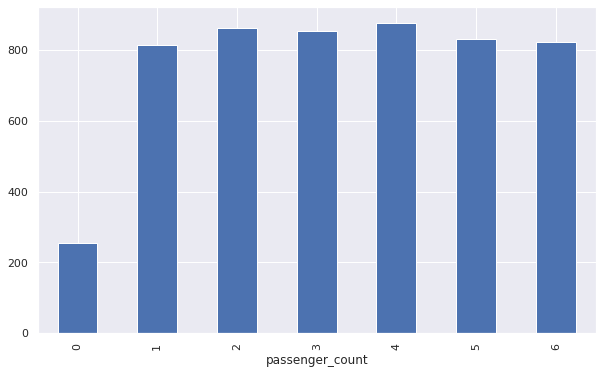

In [23]:
grouped = data_train.groupby('passenger_count')['trip_duration'].mean();
grouped.plot(kind='bar');
plt.show();

## 7 Υπολογισμός συντομότερης απόστασης μεταξύ σημείων
Calculate manhattan_distance

In [24]:
for data in [data_train, data_test]:
    data['manhattan_distance'] = get_manhattan_distance(data['pickup_longitude'],
                                                     data['pickup_latitude'],
                                                     data['dropoff_longitude'],
                                                     data['dropoff_latitude'])

### Train plots

Από το scatter plot βλεπουμε οτι οσο πιο μεγάλη η απόσταση(y axis) τόσο περισότερη ώρα (x axis) παίρνει το ταξίδι.

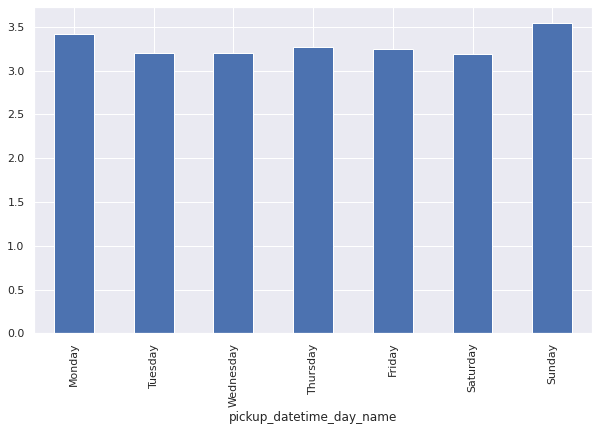

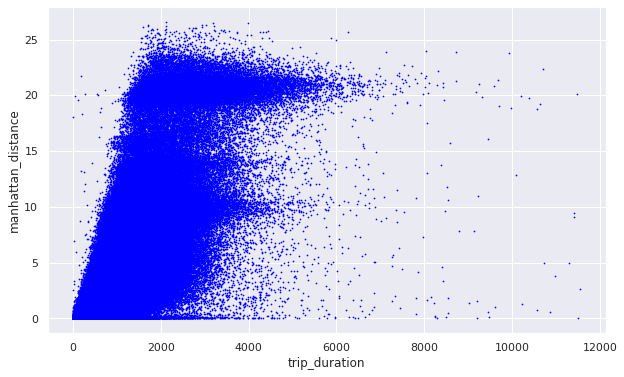

In [25]:
categories = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'];
cat_type = CategoricalDtype(categories=categories, ordered=True)
data_train['pickup_datetime_day_name'] = data_train['pickup_datetime_day_name'].astype(cat_type);

grouped = data_train.groupby('pickup_datetime_day_name')['manhattan_distance'].mean();
grouped.plot(kind='bar');
plt.show()

data_train.plot(x = 'trip_duration', y = 'manhattan_distance',c='blue', kind='scatter', s=0.5);
plt.show()

### Test plot

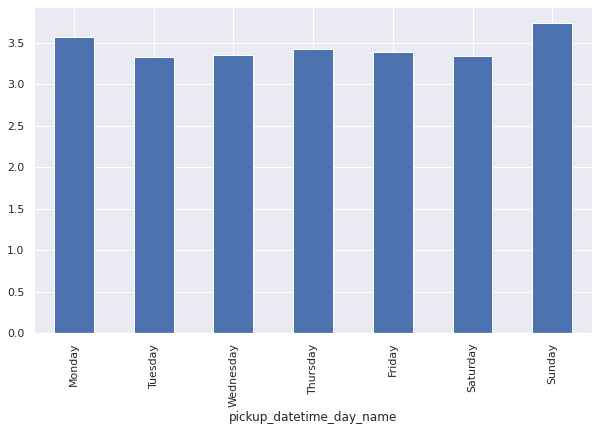

In [26]:
categories = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'];
cat_type = CategoricalDtype(categories=categories, ordered=True)
data_test['pickup_datetime_day_name'] = data_test['pickup_datetime_day_name'].astype(cat_type);

grouped = data_test.groupby('pickup_datetime_day_name')['manhattan_distance'].mean();
grouped.plot(kind='bar');
plt.show()

## 8 Υπολογισμός μέσης ταχύτηας
Calculate avg_speed

In [27]:
data_train['avg_speed'] = calc_avg_speed(data_train['manhattan_distance'], data_train['trip_duration'])

### Πώς η ώρα της ημέρας επηρεάζει την μέση ταχύτητα

Λογικό το βράδυ που έχει λιγότερη κίνηση η μέση ταχύτητα να είναι ποιό υψηλή

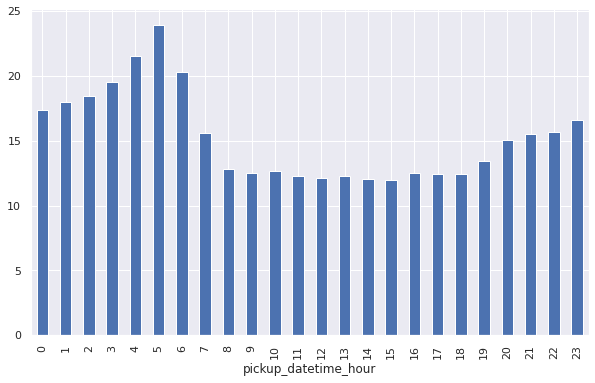

In [28]:
grouped = data_train.groupby('pickup_datetime_hour')['avg_speed'].mean();
grouped.plot(kind='bar');
plt.show();

### Πώς η μέρα της εβδομάδας επηρεάζει την μέση ταχύτητα

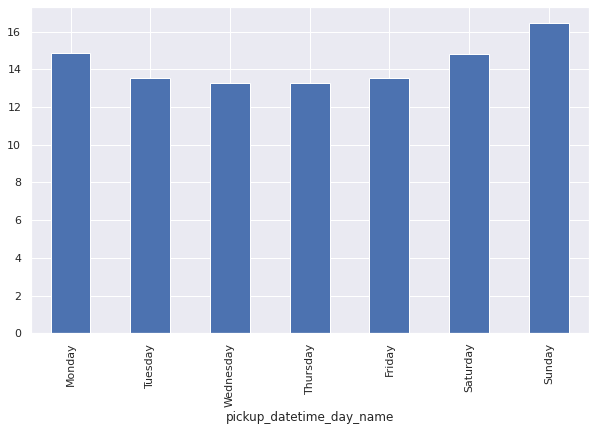

In [29]:
grouped = data_train.groupby('pickup_datetime_day_name')['avg_speed'].mean();
grouped.plot(kind='bar');
plt.show()

### Πώς ο μήνας του έτους επηρεάζει την μέση ταχύτητα

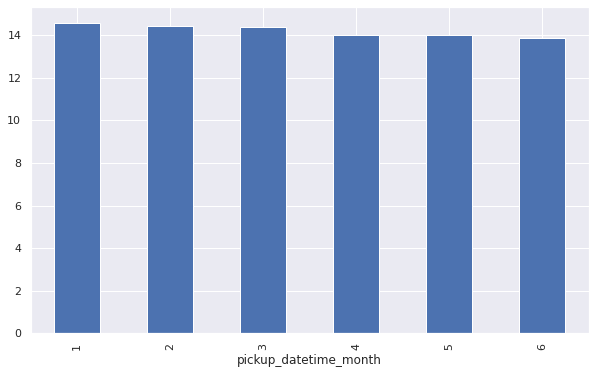

In [30]:
grouped = data_train.groupby('pickup_datetime_month')['avg_speed'].mean();
grouped.plot(kind='bar');
plt.show()

## 9 Scatter plots για τα σημεία pickup και dropoff 
Scatter plots για τα σημεία pickup και dropoff xρησιμοποιώντας τις στήλες latitude & longitude

Το scatter είναι σωστό. Αφού από τα dots απεικονίζεται ο χάρτης της New York.
Επίσης φαίνεται ξεκάθαρα ότι το manhattan έχει τα περισσότερα trips αφού έχει και τον περισσότερο κόσμο

### Pickup Scatter Plot

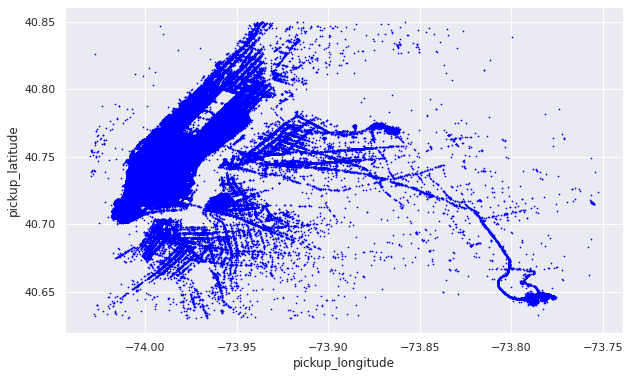

In [31]:
data_train.plot(x = 'pickup_longitude', y = 'pickup_latitude', c='blue', kind='scatter', s=0.5);
plt.show()

### Dropoff Scatter Plot

Από το pickup σε σχέση με το dropoff βλέπουμε ότι υπάρχει ένας σημαντικός αρθιμός trips που ξεκινάνε από manhattan και καταλήγουν εκτός manhattan. 

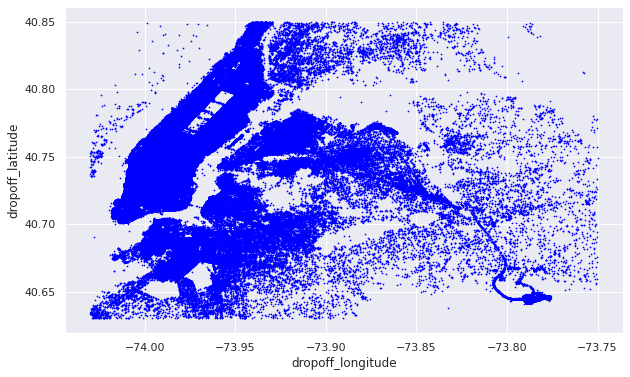

In [32]:
data_train.plot(x = 'dropoff_longitude', y = 'dropoff_latitude', c='blue', kind='scatter', s=0.5);
plt.show()

# Συσταδοποίηση και πρόβλεψη διάρκειας ταξιδιού

## 1. K-Means Clustering with Elbow Method

Από το παρακάτω cell, βρηκαμε οτι το K = 5 είναι το καλυτερο! Κάτι το οποίο είναι λογικό αφού υπάρχουν 5 σημαντικά σημεία στην Νεα Υόρκη. (Lower Manhattan, Empire State, Central Park, Port, Airport)

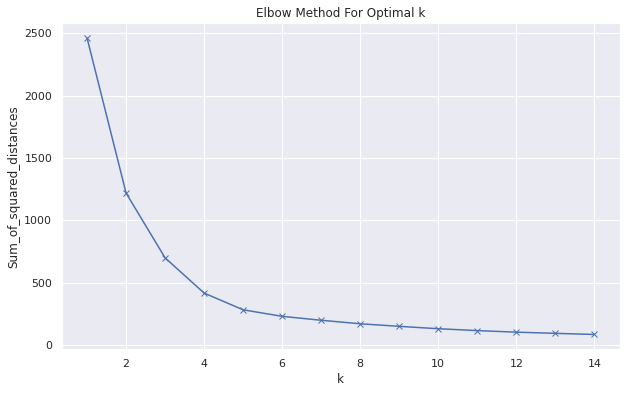

In [33]:
df = DataFrame(data_train,columns=['pickup_longitude','pickup_latitude'])

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(df)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Scatter plot με τα Latitude και Longtitude

Είναι λογικό που το Manhattan χωρίστηκε σε 3 ομάδες αφού τα περισσότερα trips είναι εκεί. Επίσης ο τρόπος που χωρίστηκαν φαίνεται να είναι βαση των κέντρων όπου βρίσκονται τα Lower Manhattan, Empire State, Central Park, Port, Airport. Αυτό είναι πολύ λογικό εφόσον εκεί υπάρχει ο περισσότερος κόσμος.

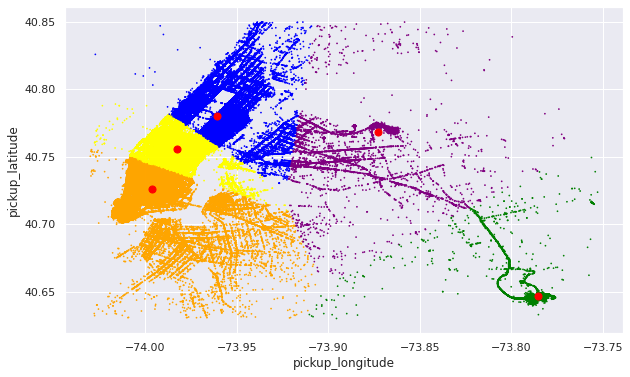

In [34]:
df = DataFrame(data_train,columns=['pickup_longitude','pickup_latitude'])
kmeans = KMeans(n_clusters=5).fit(df)
centroids = kmeans.cluster_centers_

# Format results as a pandas DataFrame
results = DataFrame([df.index,df.pickup_longitude,df.pickup_latitude,centroids[:, 0],centroids[:, 1],kmeans.labels_]).T
results.columns = ['index', 'pickup_longitude', 'pickup_latitude','centroidsX','centroidsY', 'labels']

colors = []
for i in results.labels:
    colors.append(get_color(i))

figure1 = results.plot(x='pickup_longitude', y='pickup_latitude', c = colors, s = 0.5, kind='scatter')
results.plot(ax = figure1, x='centroidsX', y='centroidsY', c = 'red', s = 50, kind='scatter')
plt.xlabel("pickup_longitude")
plt.ylabel("pickup_latitude")
plt.show()

## 2 Πρόβλεψη διάρκειας ταξιδιού με RandomForestRegressor

In [35]:
#Χρήση limit στα train data για να μην καθυστερεί υπερβολικά το GridSearch 
LIMIT_DATA = 250000

### Train the model

In [36]:
RFR = RandomForestRegressor()

# Αφαίρεση μη σημαντικών columns από το data_train
data_train['store_and_fwd_flag'] = data_train['store_and_fwd_flag'].eq('Y').mul(1)
X_train = data_train.drop(['avg_speed','dropoff_datetime_hour',	'dropoff_datetime_month',	'dropoff_datetime_year',	'dropoff_datetime_season'	,'trip_duration','log_trip_duration','id','pickup_datetime','dropoff_datetime','pickup_datetime_day_period','pickup_datetime_day_name','dropoff_datetime_day_period','dropoff_datetime_day_name'],axis=1)
feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]

y_train = data_train['log_trip_duration']
X_train = X_train[:LIMIT_DATA]
y_train = y_train[:LIMIT_DATA]

# Fit & Predict
RFR.fit(X_train.values, y_train.values)
y_pred = RFR.predict(X_train.values)

#Metrics Calculation
mae = metrics.mean_absolute_error(y_train.values,y_pred)
mse = metrics.mean_squared_error(y_train.values,y_pred)
print ("MAE: ", mae)
print ("MSE: ", math.sqrt(mse))
print ("r2:  ", RFR.score(X_train.values,y_train.values))

MAE:  0.102616646618283
MSE:  0.14655443219607756
r2:   0.9639691554342016


### Feature Importances
Είναι λογικό το **manhattan_distance** να είναι το πιο σημαντικό feature

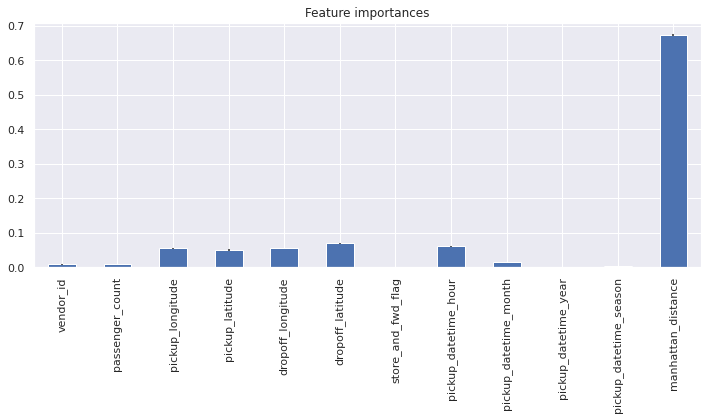

In [37]:
importances = RFR.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFR.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

## 3 GridSearchCV

In [38]:
param_grid = {
    'max_depth': [int(x) for x in np.linspace(start=10, stop=100, num=10)],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'n_estimators': [int(x) for x in np.linspace(start=10, stop=100, num=10)]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 10)
grid_search

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             verbose=10)

Το τρέξαμε με 1000 rows για να μην υπάρξει υπερβολική καθυστέρηση στην εμφάνιση των αποτελεσμάτων

In [39]:
grid_search.fit(X_train[:1000].values, y_train[:1000].values)
grid_search.best_params_

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'n_estimators': 70}

## 4 RandomForestRegressor with the parameters from GridSearchCV

In [40]:
RFR = RandomForestRegressor(bootstrap=True,max_depth=100,max_features='auto',n_estimators=40)

data_train['store_and_fwd_flag'] = data_train['store_and_fwd_flag'].eq('Y').mul(1)
X_train = data_train.drop(['avg_speed','dropoff_datetime_hour',	'dropoff_datetime_month',	'dropoff_datetime_year',	'dropoff_datetime_season'	,'trip_duration','log_trip_duration','id','pickup_datetime','dropoff_datetime','pickup_datetime_day_period','pickup_datetime_day_name','dropoff_datetime_day_period','dropoff_datetime_day_name'],axis=1)
feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]

y_train = data_train['log_trip_duration']

X_train = X_train[:LIMIT_DATA]
y_train = y_train[:LIMIT_DATA]

RFR.fit(X_train.values, y_train.values)

RandomForestRegressor(max_depth=100, n_estimators=40)

## 5 Υπολογισμός Metrics στα 2 Sets
MAE, MSE on test set

### Result of training set

In [41]:
y_pred = RFR.predict(X_train.values)
mae = metrics.mean_absolute_error(y_train.values,y_pred)
mse = metrics.mean_squared_error(y_train.values,y_pred)

print ("MAE: ", mae)
print ("MSE: ", math.sqrt(mse))
print ("r2:  ", RFR.score(X_train.values,y_train.values))

MAE:  0.10495607906544491
MSE:  0.1510801743487787
r2:   0.9617094607661103


### Result of test set

Είναι λογικό τα μην φτάνουμε τα score το train. Όμως το 0,7 είναι αρκετά καλό score

In [42]:
data_test['store_and_fwd_flag'] = data_test['store_and_fwd_flag'].eq('Y').mul(1)
X_test = data_test.drop(['id','pickup_datetime','pickup_datetime_day_period','pickup_datetime_day_name'],axis=1)
feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]

data_target['log_trip_duration'] =  np.log(data_target['trip_duration']);
y_test = data_target['log_trip_duration']

y_pred = RFR.predict(X_test.values)
mae = metrics.mean_absolute_error(y_test.values,y_pred)
mse = metrics.mean_squared_error(y_test.values,y_pred)

print ("MAE: ", mae)
print ("MSE: ", math.sqrt(mse))
print ("r2:  ", RFR.score(X_test.values,y_test.values))

MAE:  0.2853244028708192
MSE:  0.43749871004475377
r2:   0.7017293345696124


# Bonus

## 1 Εμφάνιση του χάρτη με folium

Αποθηκεύουμε τον χάρτη σε ένα HTML αρχείο.

In [43]:
df = data_train[['pickup_latitude','pickup_longitude']][:1000]
df_list = df.values.tolist()

map = folium.Map(location=df_list[0])
for coordinates in df_list:
  folium.Marker(location=[coordinates[0], coordinates[1]]).add_to(map)

map.save('map.html')